## **18C Data Challenge 1**

---

**Group: Charlie (Armon, Chelsea, Lauren, Whitney)**



---
*** Goal: Predict benign or malignant***

## **Data Exploration**

**The dataset consists of 699 cells for which you have the following features:**

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)


In [1]:
# Read the data, set the column names, check out the head
import pandas as pd
url = 'https://raw.githubusercontent.com/InsightIDX/18C/master/data_challenge_1/breast-cancer-wisconsin.csv?token=AX8jYY98DvE7t1BxNl8_5KzUq1p5vmGYks5b0zRNwA%3D%3D'
colnames= ['id', 'clump_thickness', 'u_size', 'u_shape', 'marg_adhesion', 'single_c_size', 'bare_nuc', 'bland_chromatin', 'norm_nuc', 'mitoses', 'class']
data = pd.read_csv(url, header=None, names=colnames)

data.head()

,id,clump_thickness,u_size,u_shape,marg_adhesion,single_c_size,bare_nuc,bland_chromatin,norm_nuc,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


**Data Cleaning**

The classes are labeled 2 and 4 for benign and malignant, which isn't particularly useful for modeling. Change to 0 and 1 to one-hot-encode and make modeling easier.

In [2]:
# Transform class column into better labels (2 (benign) is now 0 and 4 (malignant) is now 1)
data['class'] = data['class']/2 - 1
data['class'] = data['class'].astype(int)
data.head()

,id,clump_thickness,u_size,u_shape,marg_adhesion,single_c_size,bare_nuc,bland_chromatin,norm_nuc,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


We also need to check for missing values. Let's check for odd variable types.

In [3]:
# Check for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                 699 non-null int64
clump_thickness    699 non-null int64
u_size             699 non-null int64
u_shape            699 non-null int64
marg_adhesion      699 non-null int64
single_c_size      699 non-null int64
bare_nuc           699 non-null object
bland_chromatin    699 non-null int64
norm_nuc           699 non-null int64
mitoses            699 non-null int64
class              699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


Looks like the Bare Nuclei column is an object type, which seems weird. Let's check what it is and see how many weird values there are.

In [4]:
data['bare_nuc'].unique()


array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [5]:
#how many '?' are there?
data['bare_nuc'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuc, dtype: int64

Looks like there's only 16 "?" in the dataset, so lets change those to NaNs so they're easier to handle and convert the whole column to floats.

In [6]:
data['bare_nuc'] = data['bare_nuc'].replace({'?':None})
data['bare_nuc'] = data['bare_nuc'].astype(float)
#check it
data.dtypes
#check it
data['bare_nuc'].unique()

array([ 1., 10.,  2.,  4.,  3.,  9.,  7., nan,  5.,  8.,  6.])

Ok, that looks much better. Now let's get back to data exploration.


---



**Histograms and Scatterplots**

First things first, let's check to make sure the class column really is binary.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


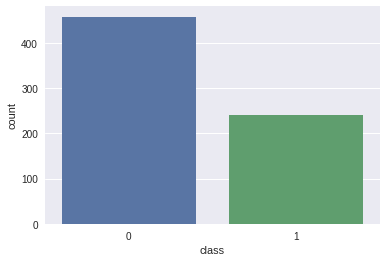

In [7]:
#All the histograms!

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure()
sns.countplot(x="class", data=data)

Yep, we're a little unbalanced, but definitely a binary classification. Now lets check the rest of our variables (everything but the ID numbers) to see what their distributions look like and see if any might be dependent on each other with a pairplot.

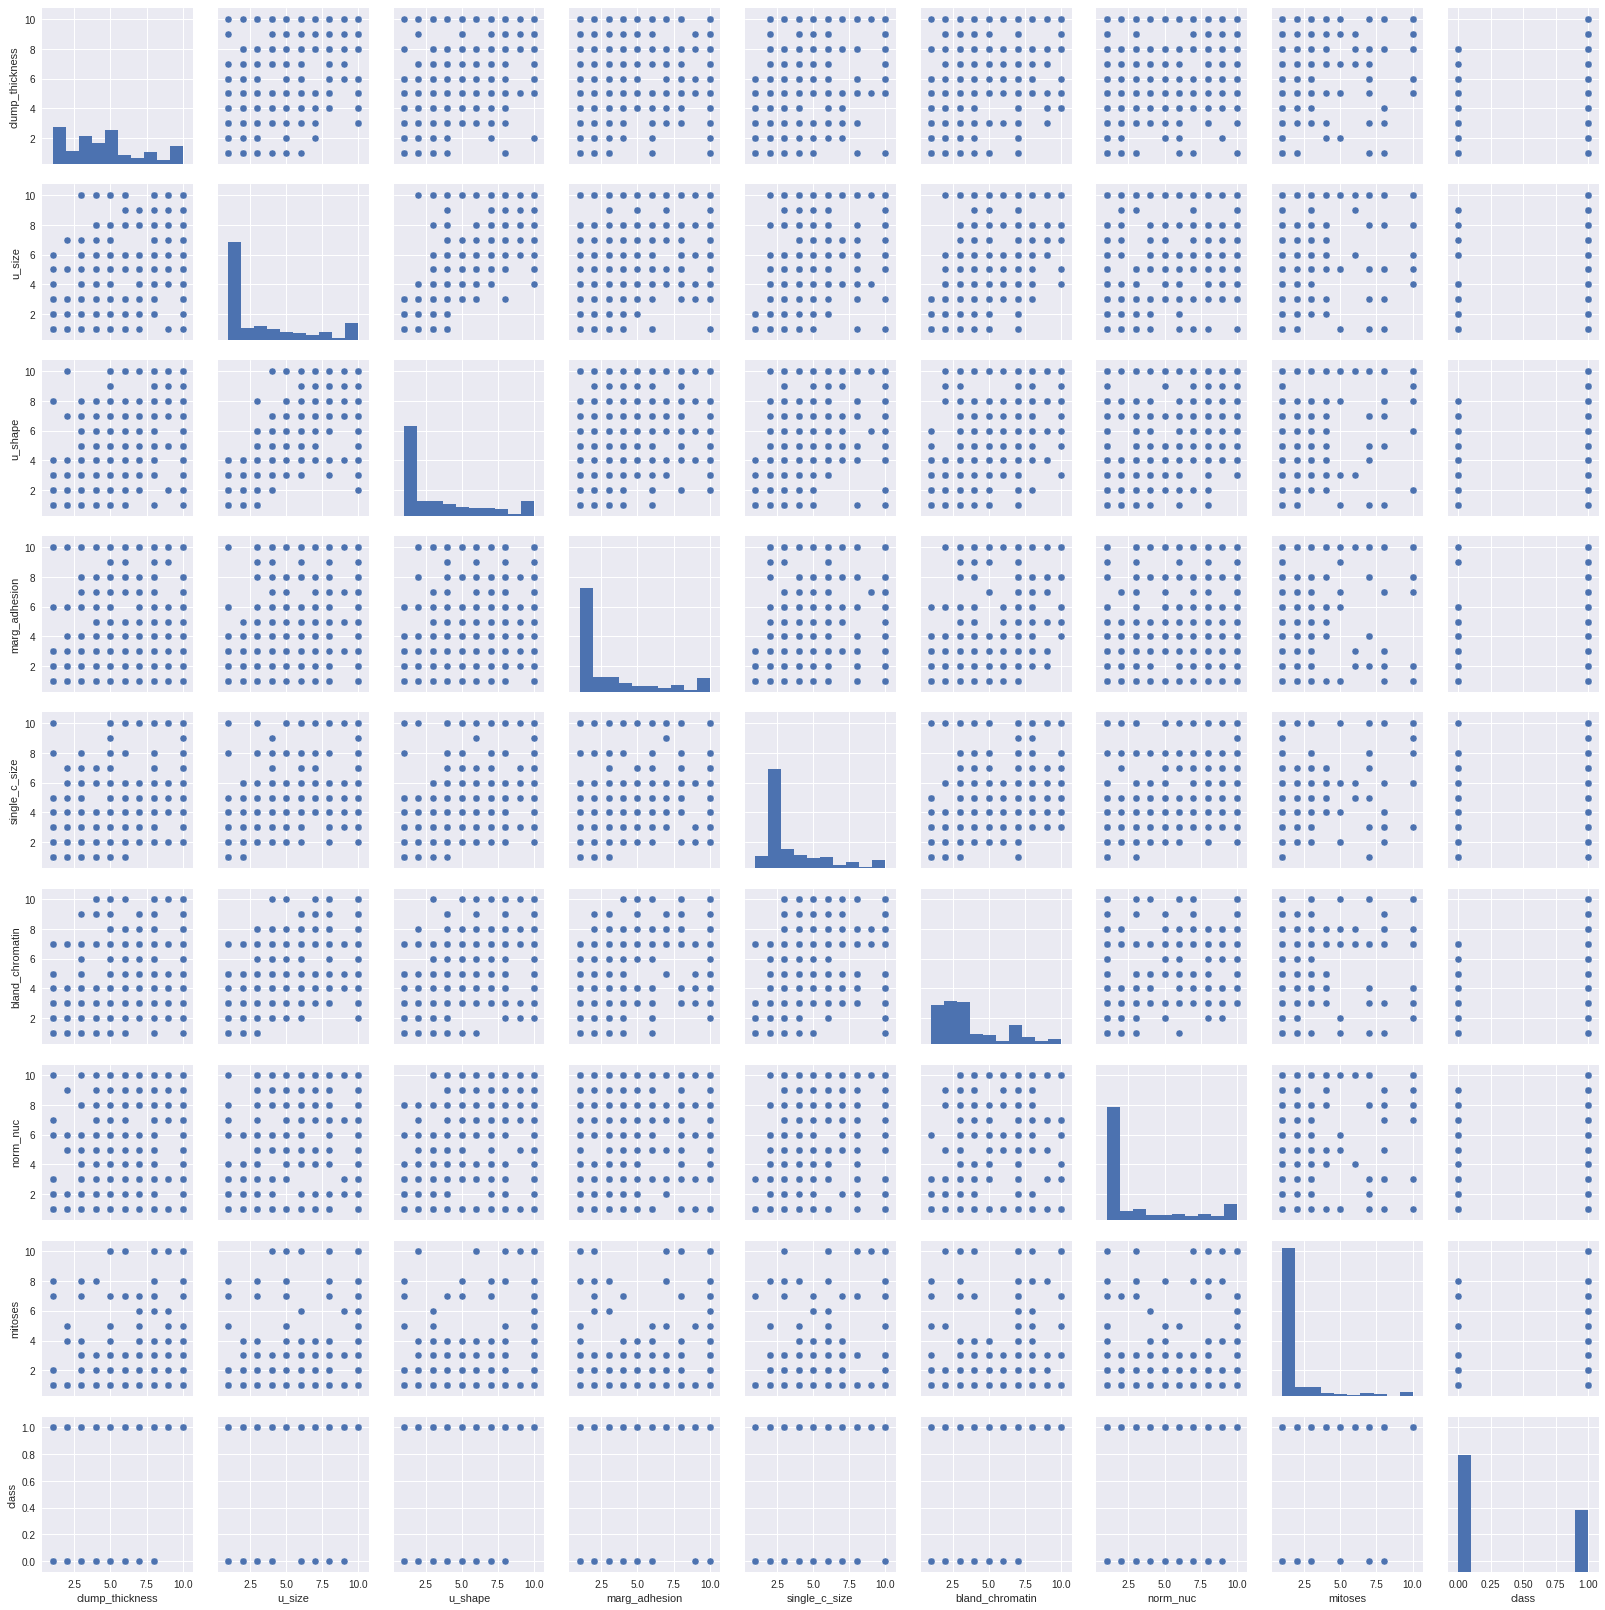

In [8]:
plt.figure()
sns.pairplot(data, vars=['clump_thickness', 'u_size', 'u_shape', 'marg_adhesion', 'single_c_size', 'bland_chromatin', 'norm_nuc', 'mitoses', 'class'])

 **Correlation Matrix**



*   Identified that u_size, u_shape, and bare_nuc are the most important features.
*   Mitosis was the least important.







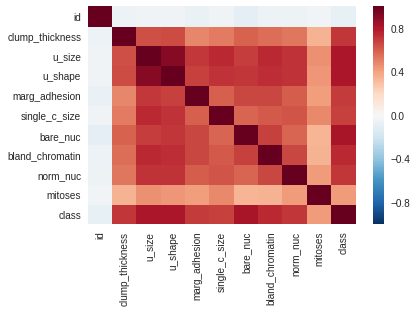

In [10]:
# correlation matrix (ranges from 1 to -1)
data.corr()


# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(data.corr())


Bare nuclei are important, so we need to use them, but there are NaNs. Since there's only a few NaNs, let's just drop those rows. We can worry about imputation later if we need more data. Since we're getting rid of the NaNs, we can also convert the whole column to ints.

In [0]:
data = data.dropna()
data['bare_nuc'] = data['bare_nuc'].astype(int)



# **Modeling**

---
We tested several logistic regression models. First, we started with basic logistic regression, splitting our data into training and testing sets. Initially, we used 10% of the data for testing, but this returned results with >98% accuracy and we had many false negatives (indicating that the tumor was malignant despite our results saying it was benign). To ensure we were accounting for our small sample size, we increased the testing set to 25% of the data. 

Our target variable was the "Class" column, which tells us whether or not the biopsy returned benign or malignant results. 


In [0]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# Split data for validation 
X = data[colnames[1:-1]]
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [0]:
#Fit logistic regression to training set
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

#Predict test set results and create confusion matrix
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
#from sklearn import predict_proba
tn_log, fp_log, fn_log, tp_log = confusion_matrix(y_test, y_pred).ravel()

In [37]:
#Classifier score
from sklearn.metrics import recall_score
score_log = round(classifier.score(X_test, y_test), 3)
recall_log = round(recall_score(y_pred, y_test), 3)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print(classification_report(y_train, classifier.predict(X_train)))


             precision    recall  f1-score   support

          0       0.93      0.96      0.94       107
          1       0.93      0.88      0.90        64

avg / total       0.93      0.93      0.93       171

             precision    recall  f1-score   support

          0       0.98      0.99      0.98       337
          1       0.97      0.96      0.97       175

avg / total       0.98      0.98      0.98       512



Let's double-check that our train-test-split is pulling similarly distributed data for both the training and test sets.

([array([104.,  48.,  41.,  74.,  62.,  93.,  24.,  20.,  34.,  12.]),
  array([280.,  48.,  35.,  41.,  25.,  23.,  20.,  11.,  23.,   6.]),
  array([257.,  41.,  48.,  42.,  30.,  24.,  20.,  24.,  21.,   5.]),
  array([296.,  40.,  43.,  42.,  28.,  17.,  15.,   9.,  19.,   3.]),
  array([ 32.,  27., 285.,  54.,  37.,  26.,  31.,   4.,  15.,   1.]),
  array([307.,  97.,  25.,  18.,  17.,  18.,   3.,   6.,  16.,   5.]),
  array([110.,  19., 125., 124.,  24.,  22.,   6.,  54.,  23.,   5.]),
  array([321.,  47.,  30.,  29.,  10.,  15.,  17.,  12.,  17.,  14.]),
  array([428.,  10.,  23.,  24.,   8.,   4.,   2.,   6.,   7.,   0.])],
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 9 Lists of Patches objects>)

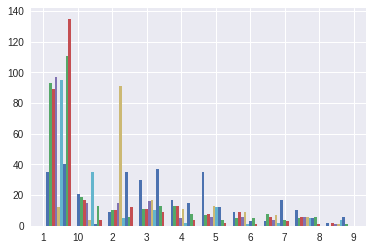

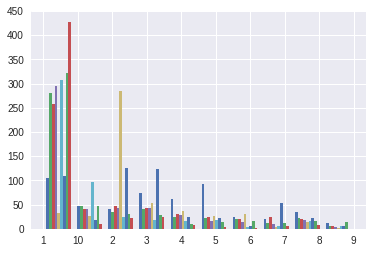

In [21]:
plt.figure()
plt.hist(X_test, bins=10)

plt.figure()
plt.hist(X_train, bins=10)

**Logistic Regression with Cross-Validation**

Let's try a 5-fold cross-validation model to see how the results differ from using a simple training / testing split. The model using 5-fold cross validation resulted in lower accurracy, precision, and recall than the logistic regression. We examined the documentation and realized that the default solver for logisitic regression using 5-fold cross validation was the lbfgs solver. We learned that the liblinear solver was better for smaller datasets and decided to test the model using a different solver. 

In [38]:
# logistic regression five-fold cross validation with lbfgs solver

from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X, y)

yCV_pred = clf.predict(X)

clf.predict_proba(X).shape
clf.score(X, y) 

tn_cv_lbfgs, fp_cv_lbfgs, fn_cv_lbfgs, tp_cv_lbfgs = confusion_matrix(y, yCV_pred).ravel()
score_cv_lbfgs = round(classifier.score(X, yCV_pred), 3)
recall_cv_lbfgs = round(recall_score(y, yCV_pred), 3)

from sklearn.metrics import classification_report
print(classification_report(y, yCV_pred))

             precision    recall  f1-score   support

          0       0.68      1.00      0.81       444
          1       1.00      0.11      0.20       239

avg / total       0.79      0.69      0.60       683



**Logistic Regression and Cross-Validation:**

Logistic Regression with 5-fold cross-validation again, but this time using liblinear solver for the cross-validation because that is the preset solver for logistic regression without cross-validation.
This way, we can run it with five-fold cross-validation *with* the liblin solver.

In [39]:
#log regression 5-fold cross validation with liblinear solver
from sklearn.linear_model import LogisticRegressionCV
clf_liblin = LogisticRegressionCV(solver='liblinear', cv=5, random_state=0).fit(X, y)

yCV_pred_liblin = clf_liblin.predict(X)

tn_cv_liblin, fp_cv_liblin, fn_cv_liblin, tp_cv_liblin = confusion_matrix(y, yCV_pred_liblin).ravel()
score_cv_liblin = round(classifier.score(X, yCV_pred_liblin), 3)
recall_cv_liblin = round(recall_score(y, yCV_pred_liblin), 3)

from sklearn.metrics import classification_report
print(classification_report(y, yCV_pred_liblin))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       444
          1       0.96      0.95      0.96       239

avg / total       0.97      0.97      0.97       683



**Logistic Regression (with liblin solver) and validation with class weights (preset is lbfgs)**

Fitting logistic regression to training set with class weights

We're now going to make some class weights to deal with the class-imbalance due to the difference in number of benign and malignant observations, so it is worth seeing if this improves things.

How it is working:
The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [40]:
#logistic regression  liblinear   (preset )
#validation with class weights (preset is lbfgs)
#Fit logistic regression to training set with class weights
classifier_weights = LogisticRegression(class_weight='balanced')
classifier_weights.fit(X_train, y_train)

#Predict test set results and create confusion matrix
y_pred_weight = classifier_weights.predict(X_test)

tn_log_weight, fp_log_weight, fn_log_weight, tp_log_weight = confusion_matrix(y_test, y_pred_weight).ravel()

#Basic score function won't work because class weights- use sklearn.metrics accuracy score instead
#score = classifier_weights.score(X_test, y_pred_weight)
from sklearn.metrics import accuracy_score
score_log_weight = round(accuracy_score(y_test, y_pred_weight), 3)
recall_log_weight = round(recall_score(y_test, y_pred_weight), 3)

print(classification_report(y_test, y_pred_weight))

             precision    recall  f1-score   support

          0       0.95      0.96      0.96       107
          1       0.94      0.92      0.93        64

avg / total       0.95      0.95      0.95       171



**5-fold cross validation using the liblinear solver and adding class weights**

Finally, we implemented a 5-fold cross validation using the liblinear solver and balancing class weights. 

In [41]:
# logistic regression with 5-fold cross validation with liblinear solver
# We are adding class weights to the imbalanced attributes of the class feature 
#  (benign and malignant- there are 444 benign and 239 malignant)

clf_weight = LogisticRegressionCV(solver='liblinear', cv=5, random_state=0, class_weight='balanced').fit(X, y)

yCV_pred_weight = clf_weight.predict(X)

tn_cv_weight, fp_cv_weight, fn_cv_weight, tp_cv_weight = confusion_matrix(y, yCV_pred_weight).ravel()
score_cv_weight = round(accuracy_score(y, yCV_pred_weight), 3)
recall_cv_weight = round(recall_score(y, yCV_pred_weight), 3)

print(classification_report(y, yCV_pred_weight))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       444
          1       0.95      0.98      0.96       239

avg / total       0.98      0.98      0.98       683



# **Final Results**

The cross validation model trained with the liblinear solver and class balancing had the lowest false negatives. 

# **Understanding the cross-validation and accuracy:**

True Positives = Predicts malignant and is malignant

False positive = Predicts malignant but  is actually benign

True negative = Predicts benign and is actually benign

False negative = Predicts benign but is actually malignant



---
Recall = false negatives

Precision = false positives

*(Remember: If false positives go down, the precision goes up.)*


---



**Think about the problem:**
*For this specific problem we want high recall (=low false negatives) 
because it is better to send someone for more testing and have them 
find out their tumor is benign than to send them home thinking their 
tumor is benign when it is actually malignant*

Therefore, accuracy is less important than the actual values in the 
classification report; if you know you have high recall and high 
precision then accuracy therefore also high.



In [42]:
import numpy as np

results_table = pd.DataFrame(np.array([["Logistic regression w/liblin", tp_log, fp_log, tn_log, fn_log, score_log, recall_log], 
                ["Logistic regression w/liblin & balanced classes", tp_log_weight, fp_log_weight, tn_log_weight, fn_log_weight, score_log_weight, recall_log_weight],
                ["Cross validation w/lbfgs", tp_cv_lbfgs, fp_cv_lbfgs, tn_cv_lbfgs, fn_cv_lbfgs, score_cv_lbfgs, recall_cv_lbfgs],
                ["Cross validation w/liblin", tp_cv_liblin, fp_cv_liblin, tn_cv_liblin, fn_cv_liblin, score_cv_liblin, recall_cv_liblin],
                ["Cross validation w/liblin & balanced classes", tp_cv_weight, fp_cv_weight, tn_cv_weight, fn_cv_weight, score_cv_weight, recall_cv_weight]]),
                            columns=["Model", "True positives", "False positives", "True negatives", "False negatives", "Accuracy", "Recall"])
results_table.style.set_table_styles([dict(selector="th",props=[('max-width', '10px')])])

display(results_table)

,Model,True positives,False positives,True negatives,False negatives,Accuracy,Recall
0,Logistic regression w/liblin,56,4,103,8,0.93,0.933
1,Logistic regression w/liblin & balanced classes,59,4,103,5,0.947,0.922
2,Cross validation w/lbfgs,27,0,444,212,0.698,0.113
3,Cross validation w/liblin,228,10,434,11,0.981,0.954
4,Cross validation w/liblin & balanced classes,234,12,432,5,0.975,0.979


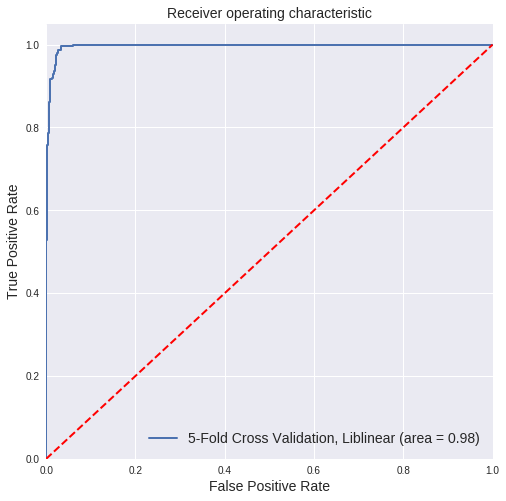

In [44]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, clf_weight.predict(X))
fpr, tpr, thresholds = roc_curve(y, clf_weight.predict_proba(X)[:,1])
plt.figure(figsize=[8, 8], facecolor='w')
plt.plot(fpr, tpr, label='5-Fold Cross Validation, Liblinear (area = %0.2f)' % logit_roc_auc, linewidth=2.0)
plt.plot([0, 1], [0, 1],'r--', linewidth=2.0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size = 14)
plt.title('Receiver operating characteristic', size=14)
plt.legend(loc="lower right", prop={'size':14})
plt.savefig('Log_ROC')
plt.show()